In [1]:
import pickle

In [2]:
with open("../qm9_dataset/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)
    
with open("best_krr_model.pkl", "rb") as f:
    model = pickle.load(f)

/Users/royalty/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator KernelRidge from version 1.6.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/royalty/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MultiOutputRegressor from version 1.6.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
import torch
from sklearn.model_selection import train_test_split
import numpy as np

def prepare_dataset(loaded_data):
    """
    Prepare the dataset for training and testing.
    
    Parameters:
    -----------
    loaded_data : dict
        Dictionary containing features and labels
    
    Returns:
    --------
    tuple
        Tuple containing training and testing data
    """
    all_features = loaded_data["features"]
    all_labels = loaded_data["labels"]
    
    print(f"Features shape: {all_features.shape}")
    print(f"Labels shape: {all_labels.shape}")
    
    np.random.seed(666)
    
    sample_size = 10000
    indices = np.random.choice(len(all_features), sample_size, replace=False)
    sampled_features = all_features[indices]
    sampled_labels = all_labels[indices]

    x_train, x_test, y_train, y_test = train_test_split(
        sampled_features, sampled_labels, test_size=0.2, random_state=666)

    # Convert PyTorch tensors to NumPy arrays for scikit-learn
    x_train_np = x_train.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    x_test_np = x_test.cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    # Print data shapes for confirmation
    print(f"Training data shapes: x={x_train_np.shape}, y={y_train_np.shape}")
    print(f"Testing data shapes: x={x_test_np.shape}, y={y_test_np.shape}")
    
    return x_train_np, y_train_np, x_test_np, y_test_np

x_train, y_train, x_test, y_test = prepare_dataset(dataset)

Features shape: torch.Size([23769, 25])
Labels shape: torch.Size([23769, 25])
Training data shapes: x=(8000, 25), y=(8000, 25)
Testing data shapes: x=(2000, 25), y=(2000, 25)


In [4]:
prediction = model.predict(x_test)

In [5]:
from tools.AtomAtom import AtomBlockDecomposer, AtomBlockReconstructor

carbon_reconstructor = AtomBlockReconstructor("2x0e+1x1o", "2x0e+1x1o")

irreps_structure = carbon_reconstructor.all_decomposed_irreps

lab_recons_input = {
    "parameters_array": torch.tensor(y_test[1]),
    "parameter_irrep_structure": irreps_structure,
}


pre_recons_input = {
    "parameters_array": torch.tensor(prediction[1]),
    "parameter_irrep_structure": irreps_structure,
}

diff = carbon_reconstructor.reconstruct_atom_block(lab_recons_input) - carbon_reconstructor.reconstruct_atom_block(pre_recons_input)

print(diff)

/Users/royalty/miniconda3/envs/torch/lib/python3.9/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/Users/royalty/miniconda3/envs/torch/lib/python3.9/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/Users/royalty/miniconda3/envs/torch/lib/python3.9/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/Users/royalty/miniconda3/envs/torch/lib/python3.9/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,
/Users/royalty/miniconda3/envs/torch/lib/python3.9/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, eith

tensor([[ 0.0007, -0.0063,  0.0042, -0.0045, -0.0008],
        [-0.0063,  0.0271, -0.0324,  0.0239,  0.0099],
        [ 0.0042, -0.0324,  0.0017,  0.0126, -0.0266],
        [-0.0045,  0.0239,  0.0126,  0.0296, -0.0139],
        [-0.0008,  0.0099, -0.0266, -0.0139, -0.0441]])


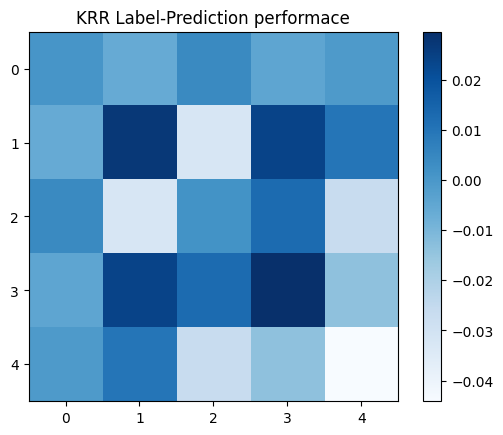

In [7]:
import matplotlib.pyplot as plt

plt.imshow(diff, cmap='Blues', interpolation='none')
plt.colorbar()
plt.title("KRR Label-Prediction performace")
plt.show()